<a  href="https://www.kaggle.com/code/gpreda/turkish-fake-names-more-experiments-with-lsh?scriptVersionId=127772028" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction


Locality sensitive hashing (LSH) is a method for quickly finding (approximate) nearest neighbors.   

The implementation by `dougian` (https://github.com/dougian/lsh) follows the approach of generating random hyperplanes to partition the dimension space in neighborhoods and uses that to hash the input space into buckets.   

To read more about LSH and this specific implementation, see https://en.wikipedia.org/wiki/Locality-sensitive_hashing#Random_projection

In this Notebook we continue the experiments with LSH, focusing on consistency, reproducibility and evaluation of the method for use with name and addresses matching.

# Analysis preparation

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from time import time
import itertools
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

In [2]:
customers_df = pd.read_csv("/kaggle/input/fake-turkish-names-csv-format/Customers_100K_Row.csv")

In [3]:
customers_df.shape

(100000, 15)

In [4]:
customers_df.head()

,ID,NAME_,SURNAME,NAMESURNAME,GENDER,BIRTHDATE,EMAIL,TCNUMBER,TELNR,CITY,TOWN,DISTRICT,STREET,POSTALCODE,ADDRESSTEXT
0,1,Melike,ÖZİPEK,Melike ÖZİPEK,K,1970-02-13,mel_ozipek@fakeyahoo.com,42151320682,555-4182308,Gaziantep,OĞUZELİ,ÇAYBAŞI MAH.,BESİ ORG.SAN.79 CADDESİ,27900,ÇAYBAŞI MAH. BESİ ORG.SAN.79 CADDESİ 27900 O...
1,2,Nurullah,ZARA,Nurullah ZARA,E,1983-01-19,nur_zara@fakeyahoo.com,60636200182,539-1901971,Diyarbakır,SUR,CEVAT PAŞA MAH.,ÇUBUKÇU 1.ÇIKMAZ SOKAK,21200,CEVAT PAŞA MAH. ÇUBUKÇU 1.ÇIKMAZ SOKAK 21200 ...
2,3,Serap Helin,ÖZALVUÇ,Serap Helin ÖZALVUÇ,K,1974-06-29,ser_ozalvuc@fakelive.com,92707435940,536-3952903,Çanakkale,GELİBOLU,GÜNEYLİ KÖYÜ,GÜNEYLİ/AY SOKAK,17502,GÜNEYLİ KÖYÜ MAH. GÜNEYLİ/AY SOKAK 17502 GEL...
3,4,Elanur Seval,ÇETİNTÜRK,Elanur Seval ÇETİNTÜRK,K,1998-04-05,ela_cetinturk@fakelive.com,73627386710,532-1391444,Osmaniye,KADİRLİ,YENİ MAH.,187. SOKAK,80750,YENİ MAH. 187. SOKAK 80750 KADİRLİ/OSMANİYE
4,5,Elmas,OKKACI,Elmas OKKACI,K,1973-02-23,elm_okkaci@fakeoutlook.com,19155799028,552-1923716,Sakarya,ADAPAZARI,SEMERCİLER MAH.,ÖNDER SOKAK,54100,SEMERCİLER MAH. ÖNDER SOKAK 54100 ADAPAZARI/...


# LSH

## Vectorization with TF-IDF

In [5]:
customers_df["CHAR_NAMESURNAME"] = customers_df["NAMESURNAME"].apply(lambda x: " ".join([c for c in x]))
customers_df[["NAMESURNAME", "CHAR_NAMESURNAME"]].head(2)
def preprocess(text):
    return nltk.word_tokenize(text)

vectorizer = TfidfVectorizer(tokenizer = preprocess,
                            ngram_range=(1,3))

start_time = time()
vect = vectorizer.fit_transform( customers_df["CHAR_NAMESURNAME"])
end_time = time()
print(f"Total time: {round(end_time-start_time, 4)} sec.")
vocabulary = vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(vocabulary)}")

Total time: 13.9513 sec.
Vocabulary size: 9630


In [6]:
from copy import copy
from itertools import combinations
import numpy as np
from pandas import DataFrame
from sklearn.metrics.pairwise import pairwise_distances


class LSH:
    def __init__(self, data):
        self.data = data
        self.model = None

    def __generate_random_vectors(self, num_vector, dim):
        return np.random.randn(dim, num_vector)

    def train(self, num_vector, seed=None):
        dim = self.data.shape[1]
        if seed is not None:
            np.random.seed(seed)

        random_vectors = self.__generate_random_vectors(num_vector, dim)
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        table = {}

        # Partition data points into bins
        bin_index_bits = (self.data.dot(random_vectors) >= 0)

        # Encode bin index bits into integers
        bin_indices = bin_index_bits.dot(powers_of_two)

        # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
        for data_index, bin_index in enumerate(bin_indices):
            if bin_index not in table:
                # If no list yet exists for this bin, assign the bin an empty list.
                table[bin_index] = []
            # Fetch the list of document ids associated with the bin and add the document id to the end.
            table[bin_index].append(data_index)

        self.model = {'bin_indices': bin_indices, 'table': table,
                      'random_vectors': random_vectors, 'num_vector': num_vector}
        return self

    def __search_nearby_bins(self, query_bin_bits, table, search_radius=2, initial_candidates=set()):
        num_vector = self.model['num_vector']
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        # Allow the user to provide an initial set of candidates.
        candidate_set = copy(initial_candidates)

        for different_bits in combinations(range(num_vector), search_radius):
            alternate_bits = copy(query_bin_bits)
            for i in different_bits:
                alternate_bits[i] = 1 if alternate_bits[i] == 0 else 0

            # Convert the new bit vector to an integer index
            nearby_bin = alternate_bits.dot(powers_of_two)

            # Fetch the list of documents belonging to the bin indexed by the new bit vector.
            # Then add those documents to candidate_set
            if nearby_bin in table:
                candidate_set.update(table[nearby_bin])

        return candidate_set

    def query(self, query_vec, k, max_search_radius, initial_candidates=set()):

        if not self.model:
            print('Model not yet build. Exiting!')
            exit(-1)

        data = self.data
        table = self.model['table']
        random_vectors = self.model['random_vectors']

        bin_index_bits = (query_vec.dot(random_vectors) >= 0).flatten()

        candidate_set = set()
        # Search nearby bins and collect candidates
        for search_radius in range(max_search_radius + 1):
            candidate_set = self.__search_nearby_bins(bin_index_bits, table,
                                                      search_radius, initial_candidates=initial_candidates)
        # Sort candidates by their true distances from the query
        nearest_neighbors = DataFrame({'id': list(candidate_set)})
        candidates = data[np.array(list(candidate_set)), :]
        nearest_neighbors['distance'] = pairwise_distances(candidates, query_vec, metric='cosine').flatten()

        return nearest_neighbors.nsmallest(k, 'distance')


In [7]:
#assumes that data is a num_observations by num_features numpy matrix
lsh_model = LSH(vect)
# num of random vectors is the power of two to generate bins
# Note: it seems that higher number of random vectors gives better result for our case
num_of_random_vectors = 11
lsh_model.train(num_of_random_vectors, seed=423142023)

**Note**: if we set the seed, we will always generate the same clusters.

Let's explore the model.

In [8]:
for item in lsh_model.model.items():
    print(f"{item[0]}: {type(item[1])}  {len(item[1]) if isinstance(item[1], (list, dict, np.ndarray)) else item[1]}")

bin_indices: <class 'numpy.ndarray'>  100000
table: <class 'dict'>  2048
random_vectors: <class 'numpy.ndarray'>  9630
num_vector: <class 'int'>  11


### bin_indices

`bin_indices` has the dimmension of our corpus of documents (100K). They represent the indices of the bins. The numbers are from 0 to `pow(2, num_of_random_vectors)`. Bin indices gives the indices of bin assigned for every item in the initial collection.

In [9]:
print(f"Length of bin indices: {len(lsh_model.model['bin_indices'])}")
print(f"Min value in the bin indices: {min(lsh_model.model['bin_indices'])}")
print(f"Max value in the bin indices: {max(lsh_model.model['bin_indices'])}")

Length of bin indices: 100000
Min value in the bin indices: 0
Max value in the bin indices: 2047


### table

`table` has dimmension of number of bins. For each of the bins, we have the indices in the original set of documents (from 0 to 99_999)). Each item in table has the dimmension of the current bin.

In [10]:
dim_vect = pow(2, num_of_random_vectors)
print(dim_vect)
print(f"Min dimmension of an index table: {min([len(lsh_model.model['table'][i]) for i in range(dim_vect)])}")
print(f"Max dimmension of an index table: {max([len(lsh_model.model['table'][i]) for i in range(dim_vect)])}")
print(f"Mean dimmension of an index table: {np.mean([len(lsh_model.model['table'][i]) for i in range(dim_vect)])}")

print(f"Min index in a table: {min([min(lsh_model.model['table'][i]) for i in range(dim_vect)])}")
print(f"Max index in a table: {max([max(lsh_model.model['table'][i]) for i in range(dim_vect)])}")


2048
Min dimmension of an index table: 4
Max dimmension of an index table: 197
Mean dimmension of an index table: 48.828125
Min index in a table: 0
Max index in a table: 99999


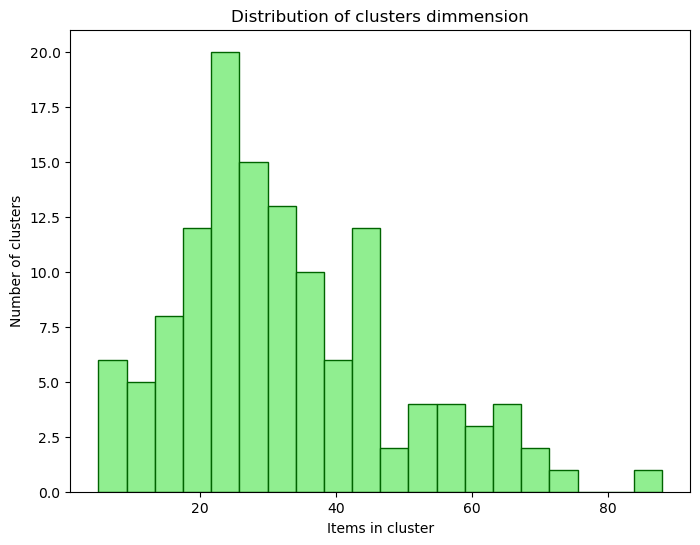

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(1,1, figsize=(8,6))
plt.hist(x=[len(lsh_model.model['table'][i]) for i in range(128)],bins=20, color='lightgreen', edgecolor="darkgreen")
plt.title("Distribution of clusters dimmension")
plt.xlabel("Items in cluster")
plt.ylabel("Number of clusters")
plt.show()

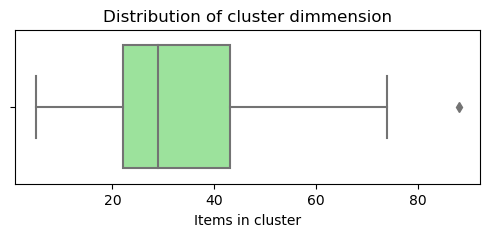

In [12]:
f, ax = plt.subplots(1,1, figsize=(6,2))
sns.boxplot(x=[len(lsh_model.model['table'][i]) for i in range(128)], color="lightgreen")
plt.title("Distribution of cluster dimmension")
plt.xlabel("Items in cluster")
plt.show()

### random_vectors

Dimmension of random vectors is the dimmension of the vocabulary.  
Each index table has dimmension equal with `num_of_random_vectors`.

In [13]:
random_vector_list = len(lsh_model.model['random_vectors'])
print(f"Dimmension of random_vector list: {random_vector_list}")

print(f"Min dimmension of an index table: {min([len(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")
print(f"Max dimmension of an index table: {max([len(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")

print(f"Min value in tables: {min([min(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")
print(f"Max value in tables: {max([max(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")
print(f"Mean value in tables: {np.mean([np.mean(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")


Dimmension of random_vector list: 9630
Min dimmension of an index table: 11
Max dimmension of an index table: 11
Min value in tables: -3.9919747918478037
Max value in tables: 4.498752905679205
Mean value in tables: -0.005339222411309787


Let's also look to an index table.

In [14]:
print(lsh_model.model['random_vectors'][0])

[ 2.6319486  -1.01344978  0.06053743 -0.18735885  0.70433823 -1.2181066
  2.31494397 -0.55411069  0.19538984 -1.18321487  0.07698847]


### num_vector

This is our preset value of vectors, i.e. value of parameter with which we initialized LSH model.

## Evaluate LSH scores



Let's see first few names (10) from the first cluster.

In [15]:
max_search_radius = 5
for cluster_index in range(0, 5):
    print("\n================================================")
    print(f"CLUSTER: {cluster_index}")
    print("================================================")
    
    vect_index_list = lsh_model.model['table'][cluster_index]
    k = 5
    vect_0 = [vect[i,:] for i in vect_index_list]
    cluster_size = len(vect_index_list)

    start_time = time()

    temp_distances = [lsh_model.query(query_vec=v, k=k, max_search_radius=max_search_radius) for v in vect_0]

    end_time = time()
    print(f"Total time for cluster {cluster_index} with {cluster_size} elements: {round(end_time-start_time, 4)} sec.")
    print(f"First 5 items from cluster: {list(customers_df.iloc[vect_index_list]['NAMESURNAME'][0:5])}")
    for i in range(5):
        print(f"\nItem to compare ({vect_index_list[i]}): {customers_df.iloc[vect_index_list[i]]['NAMESURNAME']}")
        match_items = customers_df.iloc[temp_distances[i].id][["NAMESURNAME"]].reset_index()
        match_items.columns = ["id", "NAMESURNAME"]   
        match_items = match_items.merge(temp_distances[i])
        print(match_items)                                             


CLUSTER: 0
Total time for cluster 0 with 69 elements: 3.3607 sec.
First 5 items from cluster: ['Pelin BÖBER', 'Ece EMİNGÜL', 'Yaren NAMLI', 'Melike TEDARİK', 'Sevil AYYILMAZ']

Item to compare (4572): Pelin BÖBER
      id   NAMESURNAME  distance
0  78452  Egemen BÖBER  0.328373
1  65377    Eray BÖBER  0.432820
2  51938   Masal BÖBER  0.450744
3  73098   Ferdi BÖBER  0.469443
4   6796  Cennet BÖBER  0.486553

Item to compare (6397): Ece EMİNGÜL
      id            NAMESURNAME  distance
0  52284              Ece EMREN  0.424332
1  86320  Cemile Songül EMİNGÜL  0.457156
2  87548           Suna EMİNGÜL  0.465408
3   3145            Naciye EMİN  0.526107
4  69801             Ece EMLAK)  0.558018

Item to compare (8077): Yaren NAMLI
      id           NAMESURNAME  distance
0  52061          Yaren NURKAN  0.519211
1  30820  Zeliha Aslıhan NAMLI  0.534800
2  20275       Arzu Nisa NAMLI  0.580304
3  52339     Necla Gökçe NAMLI  0.617862
4  23259            Yaren BARA  0.624354

Item to compare